In [3]:
!pip install xgboost scikit-learn
import os
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/MyDrive/data"

Mounted at /content/drive


In [5]:
def process_csv(filepath):
    df = pd.read_csv(filepath)
    amp = extract_amplitude_features(df)
    if amp.size == 0:
        raise ValueError("Amplitude array is empty")

    # NaN 제거 (혹은 무시하고 계산)
    amp = np.nan_to_num(amp)  # NaN → 0 으로 대체

    feature_vector = np.concatenate([
        amp.mean(axis=0),
        amp.std(axis=0),
        np.max(amp, axis=0),
        np.min(amp, axis=0)
    ])
    return feature_vector

In [6]:
# 복소수 CSI → 진폭 변환 함수
def extract_amplitude_features(df):
    amplitude_matrix = []
    for col in df.columns:
        if re.match(r'^_\d+$', col):  # _0 ~ _63
            cleaned = []
            for val in df[col].dropna():
                try:
                    c = complex(str(val).replace("(", "").replace(")", "").replace(" ", "").replace("nan", "0"))
                    cleaned.append(abs(c))
                except Exception:
                    cleaned.append(np.nan)
            amplitude_matrix.append(np.array(cleaned))
    result = np.array(amplitude_matrix).T if amplitude_matrix else np.array([])
    return result

In [7]:
def load_dataset_from_folders(base_dir):
    X, y = [], []
    label_map = {}

    for folder_name in sorted(os.listdir(base_dir)):
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            continue  # 폴더가 아닌 경우 무시

        label = label_map.setdefault(folder_name, len(label_map))
        files = sorted([f for f in os.listdir(folder_path) if f.lower().endswith('.csv')])

        print(f"[{folder_name}] 파일 수: {len(files)}")

        for file in files:
            file_path = os.path.join(folder_path, file)
            try:
                features = process_csv(file_path)
                X.append(features)
                y.append(label)
                print(f"{folder_name}/{file} → 라벨 {label}")
            except Exception as e:
                print(f"❌ {folder_name}/{file} 처리 실패: {e}")

    return np.array(X), np.array(y), label_map

In [8]:
# 데이터 경로 설정
base_dir = "/content/drive/MyDrive/data"

# 데이터 로드
X, y, label_map = load_dataset_from_folders(base_dir)

# 클래스 이름 정렬
class_names = [k for k, v in sorted(label_map.items(), key=lambda item: item[1])]

# 학습/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

[bathroom_clap] 파일 수: 100
bathroom_clap/bathroom_clap_1.csv → 라벨 0
bathroom_clap/bathroom_clap_10.csv → 라벨 0
bathroom_clap/bathroom_clap_100.csv → 라벨 0
bathroom_clap/bathroom_clap_11.csv → 라벨 0
bathroom_clap/bathroom_clap_12.csv → 라벨 0
bathroom_clap/bathroom_clap_13.csv → 라벨 0
bathroom_clap/bathroom_clap_14.csv → 라벨 0
bathroom_clap/bathroom_clap_15.csv → 라벨 0
bathroom_clap/bathroom_clap_16.csv → 라벨 0
bathroom_clap/bathroom_clap_17.csv → 라벨 0
bathroom_clap/bathroom_clap_18.csv → 라벨 0
bathroom_clap/bathroom_clap_19.csv → 라벨 0
bathroom_clap/bathroom_clap_2.csv → 라벨 0
bathroom_clap/bathroom_clap_20.csv → 라벨 0
bathroom_clap/bathroom_clap_21.csv → 라벨 0
bathroom_clap/bathroom_clap_22.csv → 라벨 0
bathroom_clap/bathroom_clap_23.csv → 라벨 0
bathroom_clap/bathroom_clap_24.csv → 라벨 0
bathroom_clap/bathroom_clap_25.csv → 라벨 0
bathroom_clap/bathroom_clap_26.csv → 라벨 0
bathroom_clap/bathroom_clap_27.csv → 라벨 0
bathroom_clap/bathroom_clap_28.csv → 라벨 0
bathroom_clap/bathroom_clap_29.csv → 라벨 0
bathroom_

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

# (1) 데이터 정규화
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# (2) 넘파이 → Torch Tensor 변환
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# (3) DataLoader 생성
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# MLP 모델 정의
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X.shape[1]
hidden_dim = 64
output_dim = len(np.unique(y))  # 클래스 개수

model = MLPClassifier(input_dim, hidden_dim, output_dim)


In [12]:
from sklearn.model_selection import KFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print("\n===== K-Fold 교차검증 시작 =====")

kfold = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_accuracies = []

for fold, (train_idx, val_idx) in enumerate(kfold.split(X_train)):
    print(f"\n--- Fold {fold + 1} ---")

    # Fold 데이터 분할
    X_ktrain, X_kval = X_train[train_idx], X_train[val_idx]
    y_ktrain, y_kval = y_train[train_idx], y_train[val_idx]

    # 정규화
    scaler_k = StandardScaler()
    X_ktrain_scaled = scaler_k.fit_transform(X_ktrain)
    X_kval_scaled = scaler_k.transform(X_kval)

    # 텐서 변환
    X_ktrain_tensor = torch.tensor(X_ktrain_scaled, dtype=torch.float32)
    y_ktrain_tensor = torch.tensor(y_ktrain, dtype=torch.long)
    X_kval_tensor = torch.tensor(X_kval_scaled, dtype=torch.float32)
    y_kval_tensor = torch.tensor(y_kval, dtype=torch.long)

    # DataLoader
    ktrain_loader = DataLoader(TensorDataset(X_ktrain_tensor, y_ktrain_tensor), batch_size=32, shuffle=True)

    # 모델 초기화
    model_k = MLPClassifier(input_dim, hidden_dim, output_dim).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_k.parameters(), lr=0.001)

    # 학습 루프
    for epoch in range(20):  # 교차검증은 에폭 수를 줄여도 됨
        model_k.train()
        for xb, yb in ktrain_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model_k(xb), yb)
            loss.backward()
            optimizer.step()

    # 검증
    model_k.eval()
    with torch.no_grad():
        y_kval_pred = model_k(X_kval_tensor.to(device)).argmax(dim=1).cpu().numpy()

    acc = accuracy_score(y_kval, y_kval_pred)
    kfold_accuracies.append(acc)
    print(f"Fold {fold+1} 정확도: {acc:.4f}")

print(f"\n평균 교차검증 정확도: {np.mean(kfold_accuracies):.4f}")



===== K-Fold 교차검증 시작 =====

--- Fold 1 ---
Fold 1 정확도: 0.9688

--- Fold 2 ---
Fold 2 정확도: 0.9688

--- Fold 3 ---
Fold 3 정확도: 0.9375

--- Fold 4 ---
Fold 4 정확도: 0.9531

--- Fold 5 ---
Fold 5 정확도: 0.9688

평균 교차검증 정확도: 0.9594


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 50

# 손실 저장 리스트 초기화
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)

        optimizer.zero_grad()
        outputs = model(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # 검증 손실 계산
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_test_tensor.to(device))
        val_loss = criterion(val_outputs, y_test_tensor.to(device)).item()
        val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}")


Epoch 1/50, Train Loss: 0.9159, Val Loss: 0.4935
Epoch 2/50, Train Loss: 0.3721, Val Loss: 0.2997
Epoch 3/50, Train Loss: 0.2448, Val Loss: 0.2175
Epoch 4/50, Train Loss: 0.1928, Val Loss: 0.1848
Epoch 5/50, Train Loss: 0.1616, Val Loss: 0.1454
Epoch 6/50, Train Loss: 0.1358, Val Loss: 0.1299
Epoch 7/50, Train Loss: 0.1210, Val Loss: 0.1132
Epoch 8/50, Train Loss: 0.1095, Val Loss: 0.1050
Epoch 9/50, Train Loss: 0.0983, Val Loss: 0.0984
Epoch 10/50, Train Loss: 0.0919, Val Loss: 0.0880
Epoch 11/50, Train Loss: 0.0856, Val Loss: 0.0776
Epoch 12/50, Train Loss: 0.0790, Val Loss: 0.0772
Epoch 13/50, Train Loss: 0.0765, Val Loss: 0.0709
Epoch 14/50, Train Loss: 0.0711, Val Loss: 0.0686
Epoch 15/50, Train Loss: 0.0652, Val Loss: 0.0646
Epoch 16/50, Train Loss: 0.0631, Val Loss: 0.0589
Epoch 17/50, Train Loss: 0.0600, Val Loss: 0.0659
Epoch 18/50, Train Loss: 0.0593, Val Loss: 0.0550
Epoch 19/50, Train Loss: 0.0535, Val Loss: 0.0565
Epoch 20/50, Train Loss: 0.0522, Val Loss: 0.0548
Epoch 21/


[Train Classification Report]
                 precision    recall  f1-score   support

 bathroom_clap       1.00      0.99      0.99        80
bathroom_raise       0.99      1.00      0.99        80
  bedroom_clap       1.00      1.00      1.00        80
 bedroom_raise       1.00      1.00      1.00        80

      accuracy                           1.00       320
     macro avg       1.00      1.00      1.00       320
  weighted avg       1.00      1.00      1.00       320


[Test Classification Report]
                 precision    recall  f1-score   support

 bathroom_clap       1.00      0.90      0.95        20
bathroom_raise       0.91      1.00      0.95        20
  bedroom_clap       1.00      1.00      1.00        20
 bedroom_raise       1.00      1.00      1.00        20

      accuracy                           0.97        80
     macro avg       0.98      0.97      0.97        80
  weighted avg       0.98      0.97      0.97        80



<Figure size 600x600 with 0 Axes>

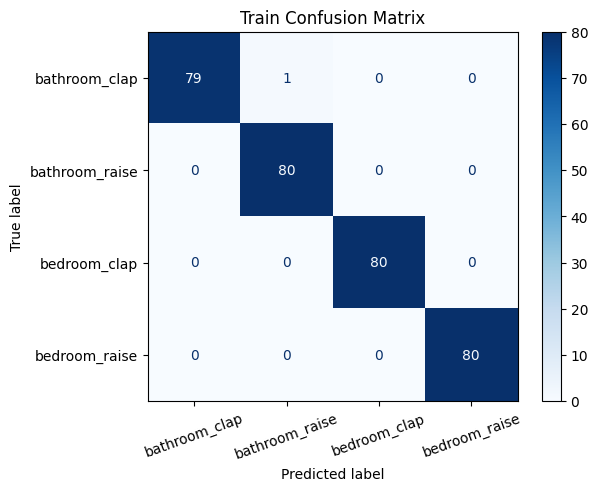

<Figure size 600x600 with 0 Axes>

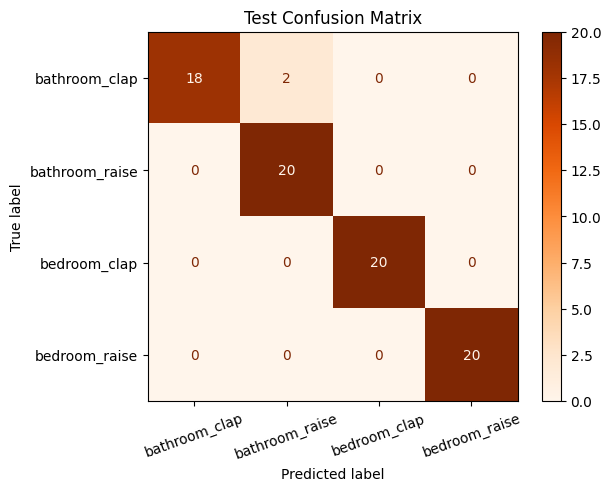

Train Accuracy: 0.9969
Test Accuracy:  0.9750


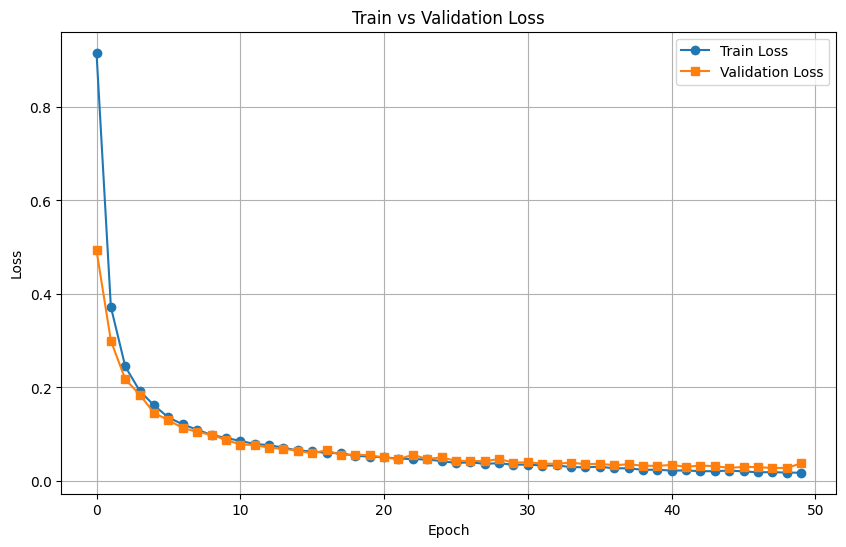

In [14]:
# ======= 평가 =======
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor.to(device)).argmax(dim=1).cpu().numpy()
    y_test_pred = model(X_test_tensor.to(device)).argmax(dim=1).cpu().numpy()

# ======= Classification Report =======
print("\n[Train Classification Report]\n", classification_report(y_train, y_train_pred, target_names=class_names))
print("\n[Test Classification Report]\n", classification_report(y_test, y_test_pred, target_names=class_names))

# ======= 혼동 행렬 (Train) =======
cm_train = confusion_matrix(y_train, y_train_pred)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
plt.figure(figsize=(6, 6))
disp_train.plot(cmap='Blues', values_format='d')
plt.title("Train Confusion Matrix")
plt.xticks(rotation=20)
plt.show()

# ======= 혼동 행렬 (Test) =======
cm_test = confusion_matrix(y_test, y_test_pred)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=class_names)
plt.figure(figsize=(6, 6))
disp_test.plot(cmap='Oranges', values_format='d')
plt.title("Test Confusion Matrix")
plt.xticks(rotation=20)
plt.show()

# ======= 정확도 출력 =======
print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Test Accuracy:  {accuracy_score(y_test, y_test_pred):.4f}")

# ======= Train vs Validation Loss 시각화 =======
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
import torch
import joblib
import json

# # 모델 저장
torch.save(model.state_dict(), "model.pth")

# # 스케일러 저장
joblib.dump(scaler, "scaler.pkl")

# 라벨 맵 저장 (dict: 클래스명 → 숫자)
with open("label_map.json", "w") as f:
    json.dump(label_map, f)

from google.colab import files

files.download("model.pth")
files.download("scaler.pkl")
files.download("label_map.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>